In [2]:
# import the necessary packages
import os
import math
import pathlib
from re import I
from imutils import paths
import numpy as np
import argparse
import imutils
import pickle
import cv2 as cv2
from matplotlib import pyplot as plt

# Vector and homography goes from img1->img2
# TimeStamp is for img1
class transform():
    def __init__(self, vector, homography, timeStamp, vectorToNow):
        self.vector = vector
        self.homography = homography
        self.timeStamp = timeStamp
        self.vectorToNow = vectorToNow

def findVectorFromTo(from_set, to_set):
    avg_point_from = [0 for x in range(len(from_set[0][0]))]
    avg_point_to = [0 for x in range(len(to_set[0][0]))]
    for point in from_set:
        point = point[0]
        for index, component in enumerate(point):
            avg_point_from[index] += component/len(from_set)
    for point in to_set:
        point = point[0]
        for index, component in enumerate(point):
            avg_point_to[index] += component/len(to_set)

    vector = [0 for x in range(len(avg_point_to))]
    for component in range(len(avg_point_to)):
        vector[component] = avg_point_to[component] - avg_point_from[component]

    return vector

# Stores data cube into a 3dimentional array with images being stored on the yz axis and each x layer representing a wavelength
# z querys the linescans
def readDataCube(filePath):
    lines = []
    with open(filePath) as f:
        lines = f.readlines()
        f.close()
        dataCube = []
        for line in lines:
            row = []
            for element in line.split("\t"):
                row.append(float(element))
            dataCube.append(row)

    np_data_cube=np.asarray(dataCube)

    # This loadedArr is a 2D array, therefore
    # we need to convert it to the original
    # array shape.reshaping to get original
    # matrice with original shape.`
    dimA=np.shape(np_data_cube)[0]          # 341 or #of wavelength buckets
    dimB=int(np.shape(np_data_cube)[1]/200) # height of scan? <- has to be I think
    dimC=200                                # len of scan

    cube_file=np.zeros(shape=(dimA,dimB,dimC),dtype=int)
    cube_file=np.reshape(np_data_cube,(dimA,dimB,dimC))
    return cube_file

### GET ALL IMAGES FROM PATH AND APPEND TO IMAGES ###
path = pathlib.Path(os.path.abspath(''))
path = os.path.join(path, "imageWriteDir")
print("[INFO] Loading images from: ", path)
imagePaths = sorted(list(paths.list_images(path)))
images = []
# loop over the image paths, load each one, and add them to our
# images to stitch list
for imagePath in imagePaths:
    timestamp = os.path.basename(os.path.normpath(imagePath))[0:-4] # strips the .png ending off the string
    image = cv2.imread(imagePath, 0) # grayscale specified
    images.append((image, timestamp))
#####################################################
print("[INFO] Images loaded")

transformUpToThisPoint = [0,0]
def getTransfromImgs(img1, img2):
    timestamp = img1[1]
    img1 = img1[0]
    img2 = img2[0]
    ### CALCULATE MATCHING KEY POINTS BETWEEN IMAGES ###
    MIN_MATCH_COUNT = 9
    #img1 = images[0] # queryImage
    #img2 = images[40] # trainImage
    # Initiate SIFT detector
    sift = cv2.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    #####################################################

    ### CALCULATE HOMOGRAPHY BETWEEN IMAGES ###
    homography = None
    v_p1_to_p2 = None
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        v_p1_to_p2 = findVectorFromTo(src_pts, dst_pts)
        transformUpToThisPoint[0]+=v_p1_to_p2[0]
        transformUpToThisPoint[1]+=v_p1_to_p2[1]

        homography, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()
        h,w = img1.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,homography)
        #img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None
        return None
    #####################################################
    ### DISPLAY MATCHING IMAGE POINTS ###
    ''' 
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                    singlePointColor = None,
                    matchesMask = matchesMask, # draw only inliers
                    flags = 2)
    img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
    plt.imshow(img3, 'gray'),plt.show()
    '''
    return transform(v_p1_to_p2, homography, timestamp, tuple(transformUpToThisPoint))
    #####################################################


'''
Algorithm steps:
1. Find the closest web cam images to each hyperspectral line scan and pair them
    Do a binary search through the image timestamps for each linescan
2. Get the transform(vector, homography) from each webcam image to the next image in order of time.
3. For each line scan, map each of its points from 
    ((lineScan).y+len(image)/2)
    ((lineScan).x+len(image[0])/2)
    lineScan*homography # all points in line scan are shifted by homorgraphy
    lineScan # all points in line scan are shifted by all vectors up to that timestamp added together
    store point data with its corisponding hyperspectral data
4. Print stored data into image
'''

# findClosestTransform does a binary search through transforms to find closest match search_time
# NOTE: search_time MUST have the form HH_MM_SS_FFFFFF if it has fewer characters the conversion will fail
def findClosestTransform(search_time, transforms):
    indexL = 0 #left
    indexC = len(transforms)//2 #center
    indexR = len(transforms)-1 #right
    considered_transform = transforms[indexC]
    while indexL < indexR:
        #print(f"L={indexL} C={indexC} R={indexR} tran={considered_transform.timeStamp}")
        if int(search_time) < int(considered_transform.timeStamp): # string to find is on the left of considered_transform
            indexR = indexC-1
            indexC = indexL+((indexR - indexL)//2)
            indexL = indexL
        elif int(search_time) > int(considered_transform.timeStamp): # string to find is on the right of considered_transform
            indexL = indexC+1
            indexC = indexL+((indexR - indexL)//2)
            indexR = indexR
        elif int(search_time) == int(considered_transform.timeStamp):
            return considered_transform
        considered_transform = transforms[indexC]
    return considered_transform


[INFO] Loading images from:  c:\Users\gabri\OneDrive\Desktop\BiiMLab\biim-lab-hyperspectral\Src\imageWriteDir
[INFO] Images loaded


In [3]:

cube_file = readDataCube('..\\data\\stitchingTestDesk.cube') # [spectrum, linescan points, linescan]
ff = open('.tempTime\\timestamps_17_00_19.pick',"rb")
line_scan_times = pickle.load(ff)
if len(line_scan_times) != len(cube_file[0,:,0]):
    print("[ERROR] LineScan times different from cube file length")


# transformArr is filtered based on if there were enough matches between two images
transformArr = []
img1 = images[0]
for img2 in images[1:]:
    transf = getTransfromImgs(img1, img2)
    if transf:
        transformArr.append(transf)
        img1 = img2
print("[INFO] Transforms calculated from images")

line_scan_transforms = []
for line_scan_index in range(len(line_scan_times)):
    line_scan_transforms.append(findClosestTransform(line_scan_times[line_scan_index], transformArr))
print(f"[INFO] {len(line_scan_transforms)} transforms paired with image timestamps")

[INFO] Transforms calculated from images
[INFO] 100 transforms paired with image timestamps


[45.40571871670812, -37.21552172574127]
[[ 1.03272694e+00  6.08753464e-02  3.20101821e+01]
 [ 9.29462685e-03  1.06606528e+00 -5.10822479e+01]
 [-1.47892707e-05  1.50198601e-04  1.00000000e+00]]
[[[320. 240.]
  [  1.   1.]]]
[[[365.64276  201.4396  ]
  [ 33.099304 -50.00012 ]]]


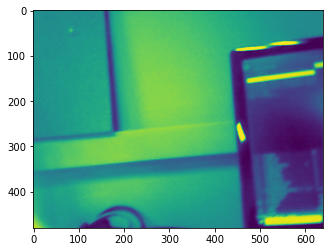

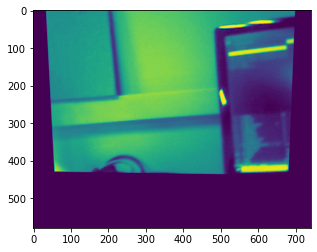

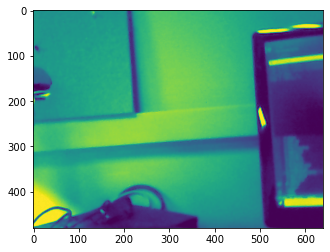

(<matplotlib.image.AxesImage at 0x1c594d82850>, None)

In [4]:


'''
'''
img1 = images[40]
img2 = images[0]
transf = getTransfromImgs(img1, img2)
print(transf.vector)
print(transf.homography)
src = np.array([[len(img1[0][0])//2, len(img1[0])//2], [1,1]], dtype='float32')
src = np.array([src])
print(src)
dst = cv2.perspectiveTransform(src, transf.homography)
print(dst)


out = cv2.warpPerspective(np.float32(img1[0]), transf.homography, (len(img1[0][0])+100, len(img1[0])+100), flags=cv2.INTER_LINEAR)


plt.imshow(np.float32(img1[0])),plt.show()
plt.imshow(out),plt.show()

plt.imshow(np.float32(img2[0])),plt.show()


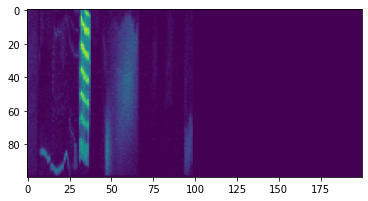

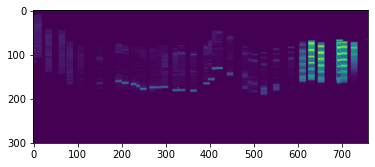

' \n### CALCULATE HOMOGRAPHY BETWEEN IMAGES ###\n# Read source image.\nim_src = images[0]\npts_src = np.array()\n# Read destination image.\nim_dst = images[1]\npts_dst = np.array()\n# Calculate Homography\nh, status = cv2.findHomography(pts_src, pts_dst)\n# Warp source image to destination based on homography\nim_out = cv2.warpPerspective(im_src, h, (im_dst.shape[1],im_dst.shape[0]))\n# Display images\ncv2.imshow("Source Image", im_src)\ncv2.imshow("Destination Image", im_dst)\ncv2.imshow("Warped Source Image", im_out)\ncv2.waitKey(0)\n#####################################################\n'

In [40]:

wavelen = 100
plt.imshow(cube_file[wavelen]),plt.show()
horizontal_dimension = 760
vertical_dimension = 300
number_of_wavelen_slices = 341

hyperCube = np.zeros((number_of_wavelen_slices,vertical_dimension+1,horizontal_dimension+1)) #TODO: [there are 341 wavelen slices, ,]
for linescan_index in range(len(cube_file[0][0])): # for each linescan
    for point_index in range(len(cube_file[wavelen])): # for each point in each linescan
        # perform point shift
        linescan_index = min(len(line_scan_transforms)-1, linescan_index)
        point_x = max(0, min(horizontal_dimension, math.floor(linescan_index - line_scan_transforms[linescan_index].vectorToNow[0]))) #+900
        point_y = max(0, min(horizontal_dimension, math.floor(point_index - line_scan_transforms[linescan_index].vectorToNow[1]))) #+500
        hyperCube[wavelen, point_y, point_x] = cube_file[wavelen][point_index][linescan_index]
        for j in range(-7, 8):
            hyperCube[wavelen, point_y, max(0, min(horizontal_dimension, point_x+j))] = cube_file[wavelen][point_index][linescan_index]

plt.imshow(hyperCube[wavelen]),plt.show()


''' 
### CALCULATE HOMOGRAPHY BETWEEN IMAGES ###
# Read source image.
im_src = images[0]
pts_src = np.array()
# Read destination image.
im_dst = images[1]
pts_dst = np.array()
# Calculate Homography
h, status = cv2.findHomography(pts_src, pts_dst)
# Warp source image to destination based on homography
im_out = cv2.warpPerspective(im_src, h, (im_dst.shape[1],im_dst.shape[0]))
# Display images
cv2.imshow("Source Image", im_src)
cv2.imshow("Destination Image", im_dst)
cv2.imshow("Warped Source Image", im_out)
cv2.waitKey(0)
#####################################################
'''